In [63]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

from tabulate import tabulate
import nltk
import string
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import everygrams
#nltk.download('punkt')

from wordcloud import WordCloud
from collections import Counter

import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pylab as plt
import seaborn as sns
# Set plot style
sns.set_theme(style="whitegrid")
import plotly.express as px

## Data

In [64]:
# Terms related with mental health.
# ref: https://www.psicanaliseclinica.com/doencas-mentais/
mental_health_terms = ['saude mental', 'saúde mental', 'depressão', 'ansiedade', 'burnout', 'anorexia', 'bulimia', 'esquizofrenia']
# Terms related with social networks.
social_net_terms = ['redes sociais', 'rede social', 'Facebook', 'Instagram', 'Twitter', 'LinkedIn', 'Tik-tok']

### Data - Preprocessing 1
all the articles about mental health - including those which are not related to social networks. 

In [65]:
raw_data = pd.read_csv('./raw_data.csv')

# Drop the unnecessary 'Unnamed: 0' column
raw_data = raw_data.drop('Unnamed: 0', axis=1)
raw_data.describe(include='all')

,news_site,tstamp,title,text,linkToNoFrame,linkToArchive
count,2681,2.681000e+03,2681,2681,2681,2681
unique,2,NaN,2681,2681,2681,2681
top,observador.pt,NaN,Rede de cuidados continuados de saúde mental a...,As unidades e equipas de cuidados continuados ...,https://arquivo.pt/noFrame/replay/201107051059...,https://arquivo.pt/wayback/20110705105955/http...
freq,2435,NaN,1,1,1,1
mean,NaN,2.017987e+13,NaN,NaN,NaN,NaN
std,NaN,2.213903e+10,NaN,NaN,NaN,NaN
min,NaN,2.004013e+13,NaN,NaN,NaN,NaN
25%,NaN,2.017031e+13,NaN,NaN,NaN,NaN
50%,NaN,2.018121e+13,NaN,NaN,NaN,NaN
75%,NaN,2.020031e+13,NaN,NaN,NaN,NaN


### Data - Preprocessing 2
all the articles about mental health regarding social networks. 

In [66]:
# This dataframe has only the articles about mental health those which are related to social networks.
df = pd.read_csv('./preprocessed_data.csv')

# Drop the unnecessary 'Unnamed: 0' column
df = df.drop('Unnamed: 0', axis=1)
df.describe(include='all')

,news_site,tstamp,title,text,linkToNoFrame,linkToArchive
count,589,5.890000e+02,588,589,589,589
unique,2,NaN,588,589,589,589
top,observador.pt,NaN,"Harry, Meghan e Oprah juntos para uma série so...",Harry e Meghan anunciaram nesta quarta-feira o...,https://arquivo.pt/noFrame/replay/201904101914...,https://arquivo.pt/wayback/20190410191430/http...
freq,562,NaN,1,1,1,1
mean,NaN,2.018258e+13,NaN,NaN,NaN,NaN
std,NaN,1.845235e+10,NaN,NaN,NaN,NaN
min,NaN,2.009122e+13,NaN,NaN,NaN,NaN
25%,NaN,2.017082e+13,NaN,NaN,NaN,NaN
50%,NaN,2.019031e+13,NaN,NaN,NaN,NaN
75%,NaN,2.020031e+13,NaN,NaN,NaN,NaN


### Preparing Visualizations

#### Number of rows over preprocessing steps

In [67]:
num_rows_raw_data = int(raw_data.count().iloc[0])
num_rows_cleaned_data = int(df.count().iloc[0])

#### Article distribution over time

In [68]:
# Convert the 'Timestamp' column to a datetime format
df['tstamp'] = pd.to_datetime(df['tstamp'], format='%Y%m%d%H%M%S', errors='coerce')
# Extract year and month for analysis
df['YearMonth'] = df['tstamp'].dt.to_period('M')

# Group by YearMonth to count articles per month
articles_per_month = df.groupby('YearMonth').size()

#### Lemmatize all the words

In [69]:
m = df.shape[0]
# Dictionaries to keep track of n-grams related to social network terms
sn_terms_dict = {}
dict_bi_grams = {}
dict_tri_grams = {}

# Setting stopwords
stop_words = set(stopwords.words('portuguese'))
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_words = []

for i in range(m):
    text = df.loc[i, 'text']
    sent_tokens = sent_tokenize(text)

    for s in sent_tokens:
        found_term = -1

        for term in social_net_terms:
            term_index = s.find(term)
            if term_index > 0:
                found_term = term_index

            # Counting the number of times the term is present in the sentence
            count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(term), s))
            sn_terms_dict[term] = sn_terms_dict.get(term, 0) + count

        if found_term < 0:
            # If no social network term is found, move to the next sentence
            continue

        # Word tokens
        word_tokens = word_tokenize(s)

        filtered_words = [
            token for token in word_tokens
            if token.lower() not in stop_words and token not in string.punctuation
            and token != "''" and token not in '–›—”`` “ ' and not token.isdigit()
        ]

        # Lemmatization
        lemmatized_words.append([lemmatizer.lemmatize(word) for word in filtered_words])

#### Word Frequency - Count the lemmas

In [70]:
# Words to emphasize with higher weights
keywords = {
    'redes sociais': 1.0,
    'rede social': 1.0,
    'Facebook': 1.0,
    'Instagram': 1.0,
    'Twitter': 1.0,
    'LinkedIn': 1.0,
    'Tik-tok': 1.0,
    'saúde mental':2.5,
    'saúde': 2.0,
    'mental': 2.0,
    'depressão': 5.0,
    'ansiedade': 3.5,
    'burnout': 2.0,
    'anorexia': 1.0,
    'bulimia': 1.0,
    'esquizofrenia': 1.50
}

# Flatten the list of all sentences' lemmatized words
flattened_lemmatized_words = [word for sublist in lemmatized_words for word in sublist]
print('Num of words: ',len(flattened_lemmatized_words))

# Count word frequencies
word_counts = Counter(flattened_lemmatized_words)

# Boost keyword weights
for keyword, weight in keywords.items():
    word_counts[keyword] = round(word_counts[keyword]*weight)

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts)

Num of words:  53618


#### Filter social network related bigrams, and trigrams

In [71]:
social_net_terms = ['redes sociais', 'rede social', 'Facebook', 'Instagram', 'Twitter', 'LinkedIn', 'Tik-tok']
# removing 'rede social' and 'redes sociais'
terms = social_net_terms[1:]

def filter_n_grams(n_grams, dict_n_grams):
    i = -1
    j = -1
    
    for ng in n_grams:
        n_gram_lower = [x.lower() for x in ng]
        should_add = -1
        i = 0
        j = 0
        
        if 'redes' in n_gram_lower and 'sociais' in n_gram_lower:
            i = n_gram_lower.index('redes')
            j = n_gram_lower.index('sociais')

        if 'rede' in n_gram_lower and 'social' in n_gram_lower:
            i = n_gram_lower.index('rede')
            j = n_gram_lower.index('social')

        if i >= 0 and i < j:
            # Devo adicionar este ngrama pois tem 'redes sociais' ou 'rede social'
            should_add = 1
            contains_unexpected_chars = 0
            for n in ng:
                if '/' in n:
                    contains_unexpected_chars = -1
                
                if n.isdigit():
                    should_add = -1
            
            if should_add > 0 and contains_unexpected_chars == 0:
                ng = tuple(t.lower() if 'redes' == t.lower() or 'sociais' == t.lower() or 'rede' == t.lower() or 'social' == t.lower() else t for t in ng)
                if ng not in dict_n_grams.keys(): 
                    dict_n_grams[ng] = 1
                else: 
                    dict_n_grams[ng] += 1  
        else:
            # Verificar se o n-grama tem algum dos outros termos. 
            # Ou seja os que não são 'redes sociais' nem 'rede social'
            contains_digit = 0
            contains_unexpected_chars = 0
            for n_word in ng:
                if '/' in n_word:
                    contains_unexpected_chars = -1
                
                for ch in n_word: 
                    if ch.isdigit():
                        # N-gramas com digitos ocorrem devido a citacoes de datas nos textos.
                        contains_digit = 1
            
            if contains_digit == 0:
                for t in terms:
                    if t in ng:
                        should_add=1

            if should_add > 0 and contains_digit == 0 and contains_unexpected_chars == 0:
                #ng = tuple(t.lower() if 'redes' == t.lower() or 'sociais' == t.lower() or 'rede' == t.lower() or 'social' == t.lower() else t for t in ng)
                if ng not in dict_n_grams.keys(): 
                    dict_n_grams[ng] = 1
                else: 
                    dict_n_grams[ng] += 1  

    return dict_n_grams

#### Create bigrams and trigrams related to social network terms

##### General bigrams and trigrams

In [72]:
bigrams = list(everygrams(flattened_lemmatized_words, 2, 2))
trigrams = list(everygrams(flattened_lemmatized_words, 3, 3))

##### Social networks bigrams and trigrams

In [73]:
# dict to keep track of n grams related to social network terms
social_net_bigram_dict = filter_n_grams(bigrams, {})
social_net_trigram_dict = filter_n_grams(trigrams, {})

##### Mental health bigrams and trigrams

In [74]:
# Function to check if a bigram contains any mental health terms
def contains_mental_health_terms(ngram, terms):
    return any(term in ngram for term in terms)

# Filter ngrams to include only those associated with mental health terms
mental_health_bigrams = [bigram for bigram in bigrams if contains_mental_health_terms(bigram, mental_health_terms)]
mental_health_trigrams = [trigram for trigram in trigrams if contains_mental_health_terms(trigram, mental_health_terms)]

# Count the frequency of each ngram
mental_health_bigram_dict = dict(Counter(mental_health_bigrams))  
mental_health_trigram_dict = dict(Counter(mental_health_trigrams))

In [75]:
# Word frequency of social_net_terms
sn_terms_dict = {term: count for term, count in word_counts.items() if term in social_net_terms}

final_sn_terms_dict = {'social network term': list(sn_terms_dict.keys()), 'count': list(sn_terms_dict.values())}
sn_terms_df = pd.DataFrame.from_dict(final_sn_terms_dict)
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(f'Frequency of Social Network term:\n{sn_terms_df.sort_values(by="count",ascending=False)}\n')

In [76]:
final_dict_social_net = {'bigram':social_net_bigram_dict.keys(), 'count':social_net_bigram_dict.values()}
bi_grams_social_net_df = pd.DataFrame.from_dict(final_dict_social_net)
#print(f'Containing social network term:\n{dict_social_net.sort_values(by="count",ascending=False)[:20]}\n')

# The scope of these changes made to
# pandas settings are local to with statement.
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(f'Bi-grams Containing Social Network term:\n{bi_grams_social_net_df.sort_values(by="count",ascending=False)}\n')

In [77]:
final_dict_social_net = {'trigram':social_net_trigram_dict.keys(), 'count':social_net_trigram_dict.values()}
tri_grams_social_net_df = pd.DataFrame.from_dict(final_dict_social_net)
#print(f'Containing social network term:\n{dict_social_net.sort_values(by="count",ascending=False)[:20]}\n')

# The scope of these changes made to
# pandas settings are local to with statement.
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(f'Tri-grams Containing Social Network term:\n{tri_grams_social_net_df.sort_values(by="count",ascending=False)}\n')

In [78]:
final_dict_mental_health = {'bigram':mental_health_bigram_dict.keys(), 'count':mental_health_bigram_dict.values()}
bi_grams_mental_health_df = pd.DataFrame.from_dict(final_dict_mental_health)

final_dict_mental_health = {'bigram':mental_health_trigram_dict.keys(), 'count':mental_health_trigram_dict.values()}
tri_grams_mental_health_df = pd.DataFrame.from_dict(final_dict_mental_health)

### Plot analysis

#### Overall analysis

##### Number of rows over preprocessing steps

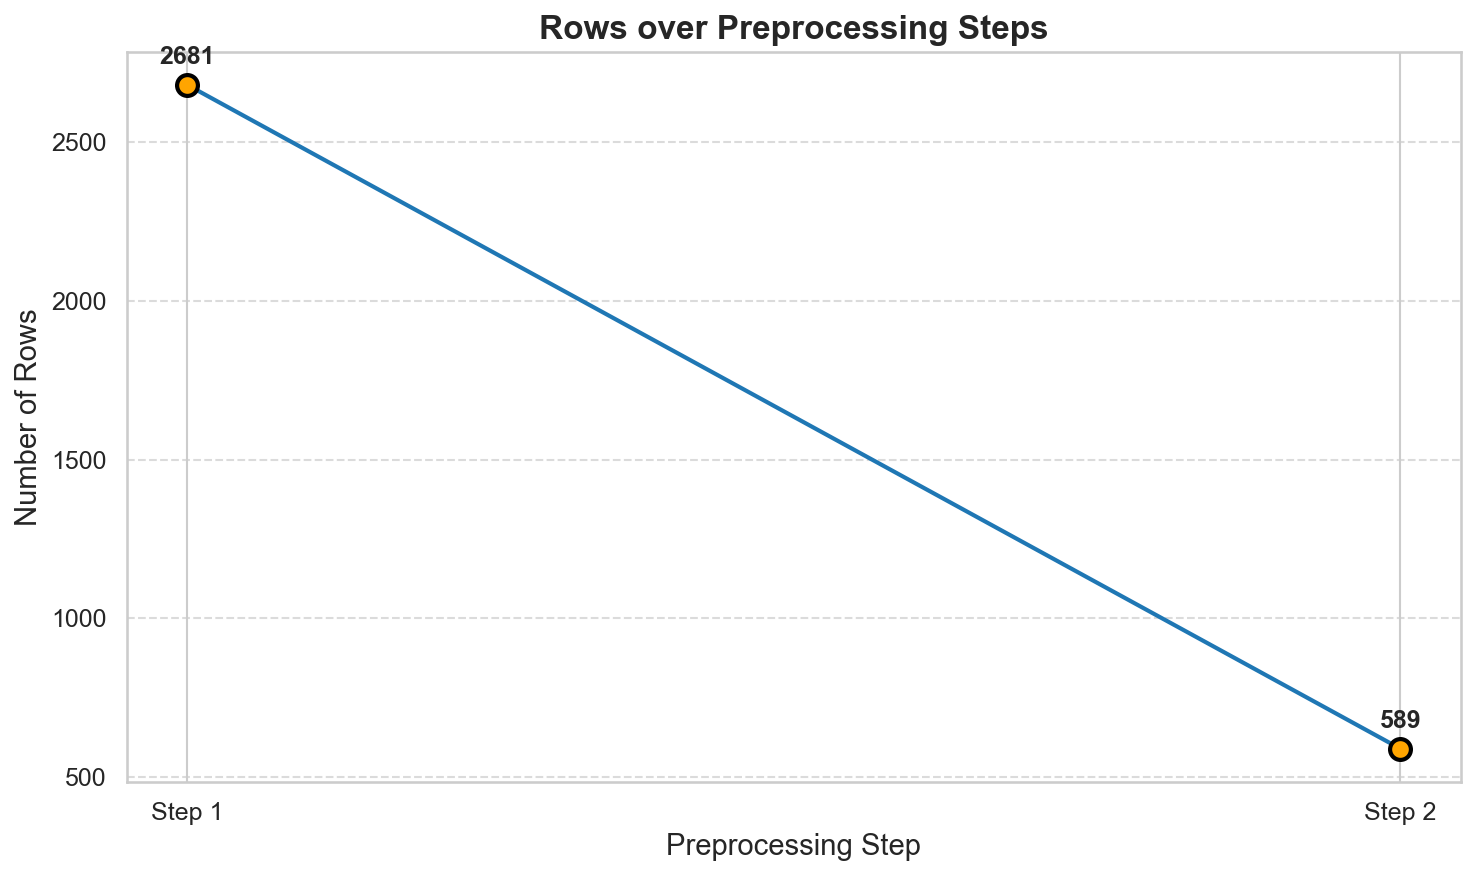

In [79]:
# Example data (replace these with your actual values)
steps = ['Step 1', 'Step 2']
row_counts = [num_rows_raw_data, num_rows_cleaned_data]

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(steps, row_counts, marker='o', color='#1f77b4', linestyle='-', linewidth=2, markersize=10, markerfacecolor='orange', markeredgewidth=2, markeredgecolor='black')

# Add titles and labels
plt.title('Rows over Preprocessing Steps', fontsize=16, fontweight='bold')
plt.xlabel('Preprocessing Step', fontsize=14)
plt.ylabel('Number of Rows', fontsize=14)

# Add grid lines with custom styles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations to highlight specific points
for i, count in enumerate(row_counts):
    plt.annotate(f'{count}', (steps[i], row_counts[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, fontweight='bold')

# Customize the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

##### Article distribution over time

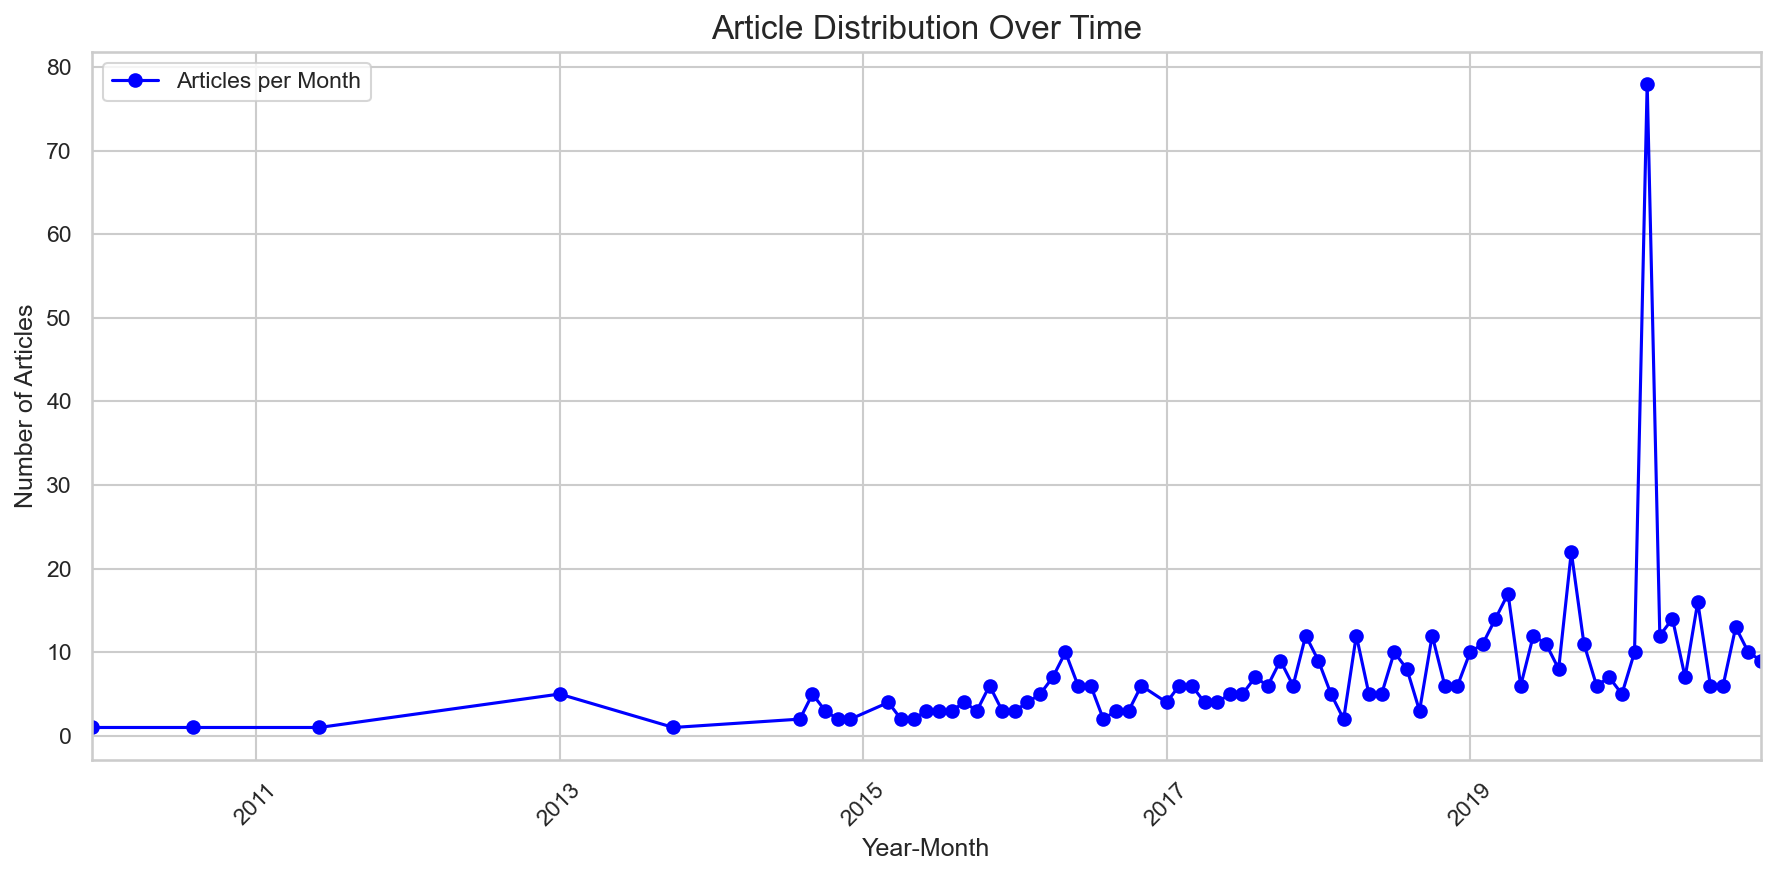

In [80]:
# Plot articles over time
plt.figure(figsize=(12, 6))
articles_per_month.plot(kind='line', marker='o', color='blue', label='Articles per Month')
plt.title('Article Distribution Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/qd/4n4c3yhd47d8nkldx7mxk4880000gn/T/ipykernel_84937/1552603140.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=news_site_distribution.values, y=news_site_distribution.index, palette='Blues_d')


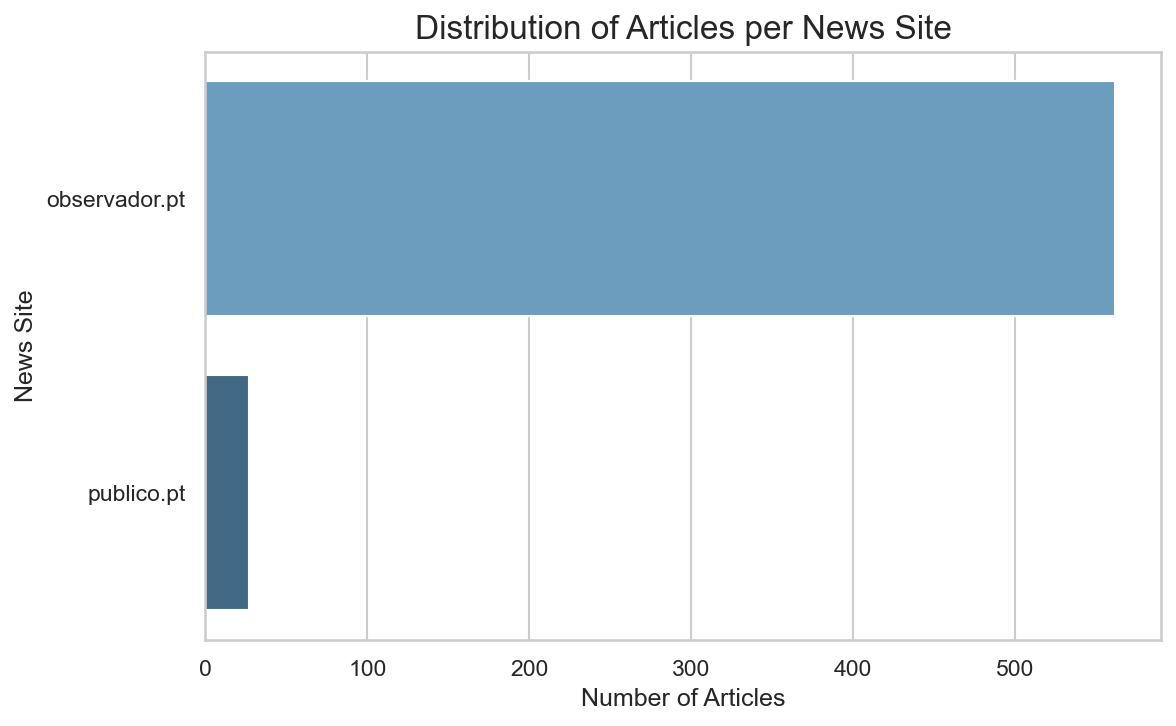

news_site
observador.pt    562
publico.pt        27
Name: count, dtype: int64


In [81]:
# Get the distribution of rows per news site
news_site_distribution = df['news_site'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=news_site_distribution.values, y=news_site_distribution.index, palette='Blues_d')
plt.title('Distribution of Articles per News Site', fontsize=16)
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('News Site', fontsize=12)
plt.tight_layout()
plt.show()

# Display the raw distribution data
print(news_site_distribution)


##### Word Cloud

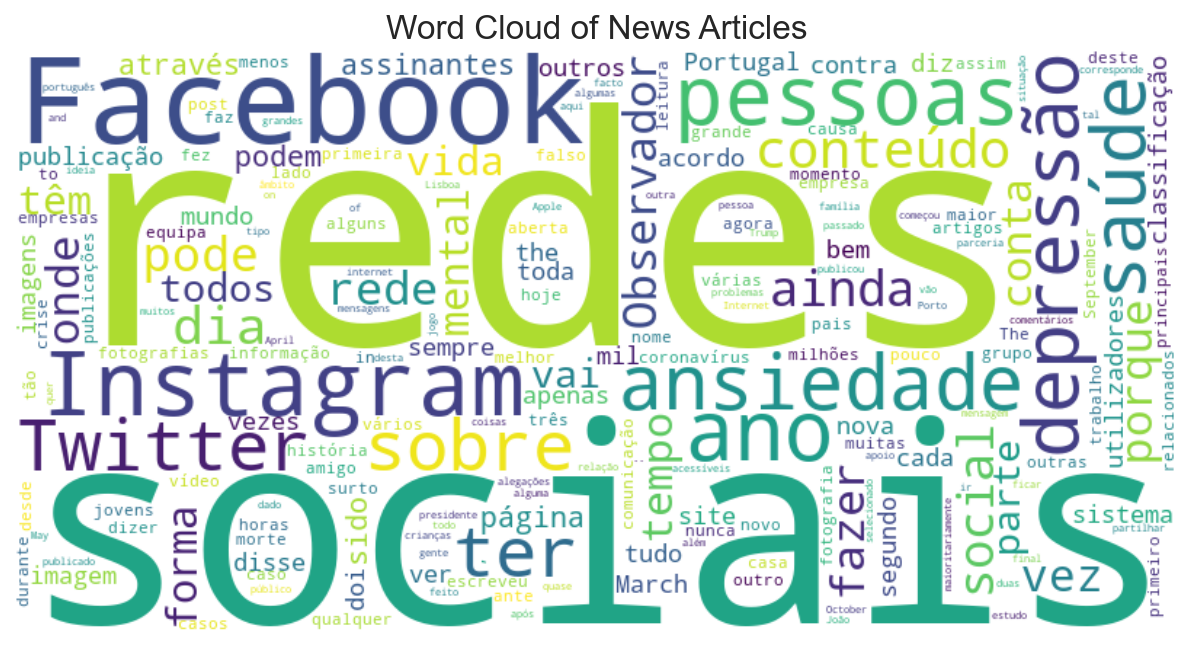

In [82]:
# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Articles', fontsize=16)
plt.show()

##### Top 20 most frequent words

/var/folders/qd/4n4c3yhd47d8nkldx7mxk4880000gn/T/ipykernel_84937/4222594127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


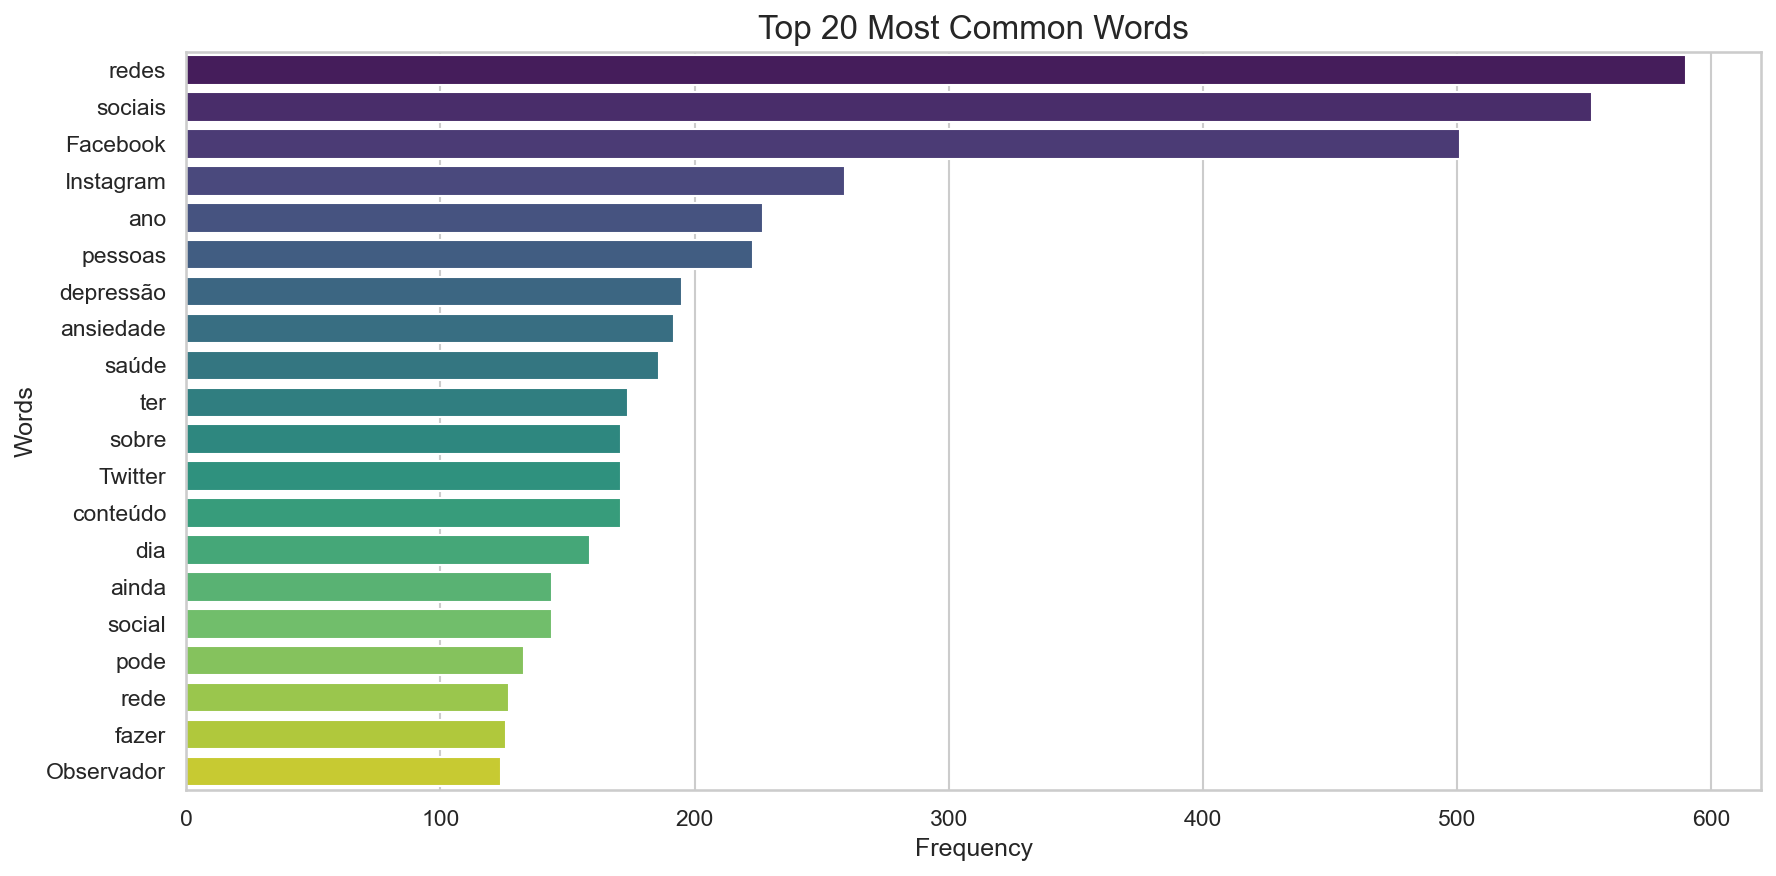

In [83]:
# Extract the top 20 most common lemmas
top_20_lemmas = word_counts.most_common(20)

# Separate the lemmas and their counts for plotting
words, counts = zip(*top_20_lemmas)
# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title('Top 20 Most Common Words', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.tight_layout()
plt.show()

#### Social Networks terms analysis

#### Word counts

##### Frequency of each social network related term 

In [84]:
top_sn_terms_df = sn_terms_df.sort_values(by="count",ascending=False)
print(tabulate(top_sn_terms_df.reset_index(drop=True), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═══════════════════════╤═════════╕
│    │ social network term   │   count │
╞════╪═══════════════════════╪═════════╡
│  0 │ Facebook              │     501 │
├────┼───────────────────────┼─────────┤
│  1 │ Instagram             │     259 │
├────┼───────────────────────┼─────────┤
│  2 │ Twitter               │     171 │
├────┼───────────────────────┼─────────┤
│  3 │ LinkedIn              │       5 │
├────┼───────────────────────┼─────────┤
│  4 │ redes sociais         │       0 │
├────┼───────────────────────┼─────────┤
│  5 │ rede social           │       0 │
├────┼───────────────────────┼─────────┤
│  6 │ Tik-tok               │       0 │
╘════╧═══════════════════════╧═════════╛


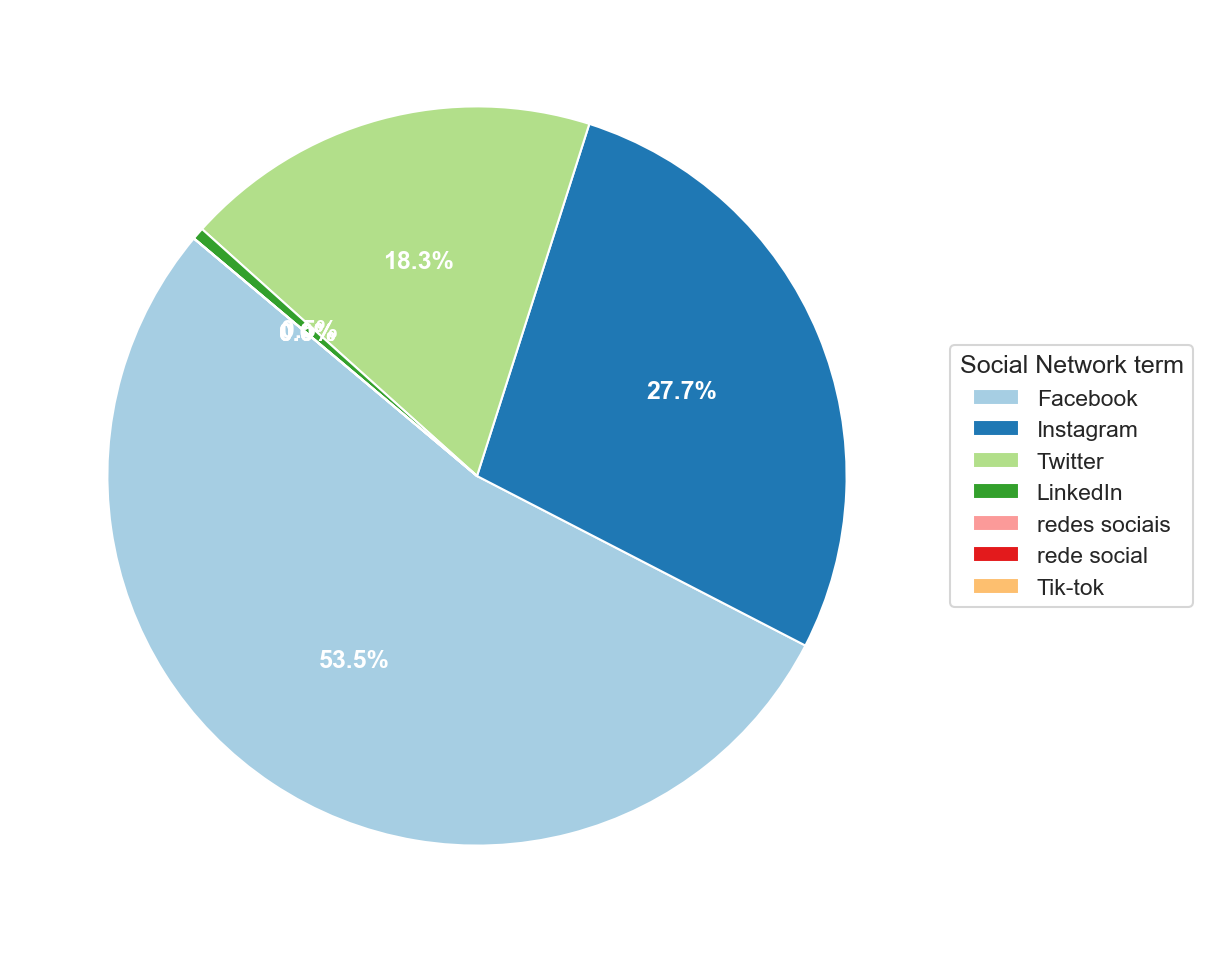

In [85]:
#top_sn_terms_df = top_sn_terms_df[top_sn_terms_df['count'] > 0]
#print(top_sn_terms_df)
# Pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    top_sn_terms_df['count'],
    labels=top_sn_terms_df['social network term'],
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color="w"),
    colors=plt.cm.Paired.colors
)

# Beautify the chart
ax.legend(wedges, top_sn_terms_df['social network term'], title="Social Network term", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=12, weight="bold")
#ax.set_title("Social Network term frequency", fontsize=16, weight="bold")
plt.show()

##### Top 10 bi-grams related to social network terms 

In [86]:
top_bi_grams_df = bi_grams_social_net_df.sort_values(by="count",ascending=False)[:10]
print(tabulate(top_bi_grams_df.reset_index(drop=True), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═══════════════════════════════╤═════════╕
│    │ bigram                        │   count │
╞════╪═══════════════════════════════╪═════════╡
│  0 │ ('redes', 'sociais')          │     541 │
├────┼───────────────────────────────┼─────────┤
│  1 │ ('rede', 'social')            │     109 │
├────┼───────────────────────────────┼─────────┤
│  2 │ ('página', 'Facebook')        │      37 │
├────┼───────────────────────────────┼─────────┤
│  3 │ ('Facebook', 'conteúdo')      │      35 │
├────┼───────────────────────────────┼─────────┤
│  4 │ ('classificação', 'Facebook') │      34 │
├────┼───────────────────────────────┼─────────┤
│  5 │ ('Facebook', 'Instagram')     │      23 │
├────┼───────────────────────────────┼─────────┤
│  6 │ ('conta', 'Instagram')        │      21 │
├────┼───────────────────────────────┼─────────┤
│  7 │ ('Facebook', 'Twitter')       │      13 │
├────┼───────────────────────────────┼─────────┤
│  8 │ ('social', 'Facebook')        │      11 │
├────┼──────────────

<Figure size 1500x900 with 0 Axes>

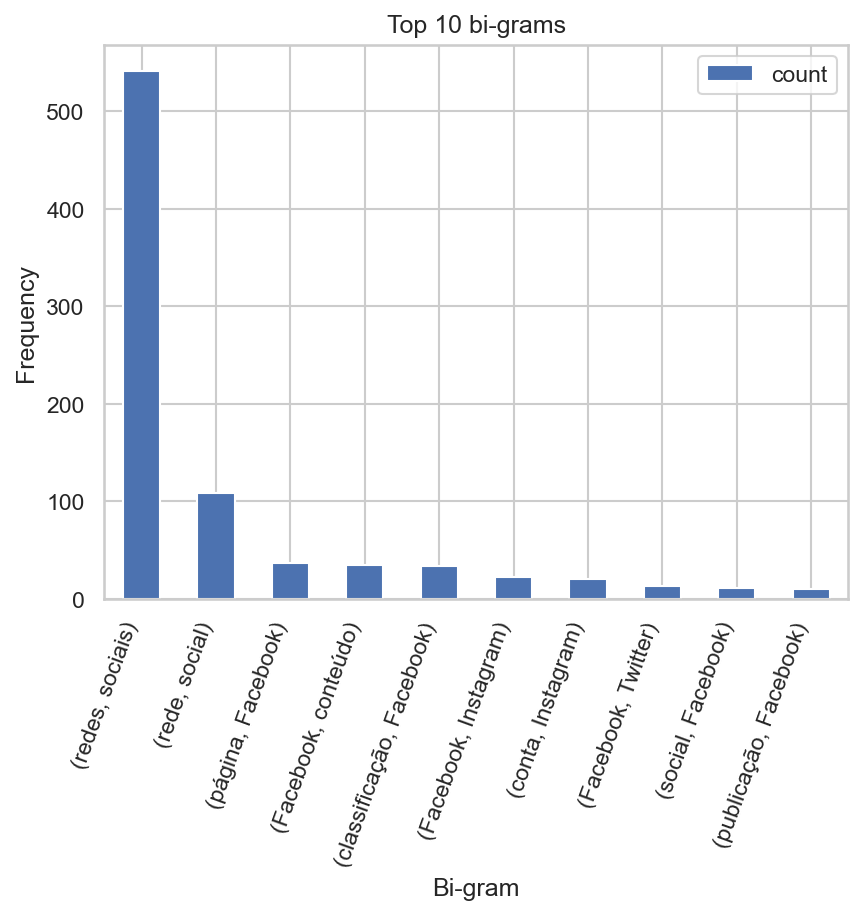

In [87]:
plt.figure(figsize=(10,6))
bi_grams_social_net_df.sort_values(by="count",ascending=False)[:10].plot.bar(x='bigram', y='count')
plt.xticks(rotation=70, ha="right")
plt.xlabel("Bi-gram")
plt.ylabel("Frequency")
plt.title("Top 10 bi-grams")
plt.show()

##### Bottom 10 bi-grams related to social network terms 

In [88]:
bottom_bi_grams_df = bi_grams_social_net_df.sort_values(by="count",ascending=True)[:10]
print(tabulate(bottom_bi_grams_df.reset_index(drop=True), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤══════════════════════════════╤═════════╕
│    │ bigram                       │   count │
╞════╪══════════════════════════════╪═════════╡
│  0 │ ('Twitter', 'Spotify')       │       1 │
├────┼──────────────────────────────┼─────────┤
│  1 │ ('atenção', 'Twitter')       │       1 │
├────┼──────────────────────────────┼─────────┤
│  2 │ ('Twitter', 'sei')           │       1 │
├────┼──────────────────────────────┼─────────┤
│  3 │ ('aconteceu', 'Twitter')     │       1 │
├────┼──────────────────────────────┼─────────┤
│  4 │ ('Twitter', 'empresa')       │       1 │
├────┼──────────────────────────────┼─────────┤
│  5 │ ('executivo.Mas', 'Twitter') │       1 │
├────┼──────────────────────────────┼─────────┤
│  6 │ ('Twitter', 'interessante')  │       1 │
├────┼──────────────────────────────┼─────────┤
│  7 │ ('Twitter', 'Todos')         │       1 │
├────┼──────────────────────────────┼─────────┤
│  8 │ ('mim', 'Twitter')           │       1 │
├────┼──────────────────────────────┼───

##### Top 10 tri-grams related to social network terms 

In [89]:
top_tri_grams_df = tri_grams_social_net_df.sort_values(by="count",ascending=False)[:10]
print(tabulate(top_tri_grams_df.reset_index(drop=True), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═════════════════════════════════════════════╤═════════╕
│    │ trigram                                     │   count │
╞════╪═════════════════════════════════════════════╪═════════╡
│  0 │ ('classificação', 'Facebook', 'conteúdo')   │      34 │
├────┼─────────────────────────────────────────────┼─────────┤
│  1 │ ('sistema', 'classificação', 'Facebook')    │      30 │
├────┼─────────────────────────────────────────────┼─────────┤
│  2 │ ('Facebook', 'conteúdo', 'FALSO')           │      27 │
├────┼─────────────────────────────────────────────┼─────────┤
│  3 │ ('através', 'redes', 'sociais')             │      22 │
├────┼─────────────────────────────────────────────┼─────────┤
│  4 │ ('rede', 'social', 'Facebook')              │      11 │
├────┼─────────────────────────────────────────────┼─────────┤
│  5 │ ('redes', 'sociais', 'onde')                │       9 │
├────┼─────────────────────────────────────────────┼─────────┤
│  6 │ ('vice-presidente', 'Facebook', 'relações') │   

<Figure size 1500x900 with 0 Axes>

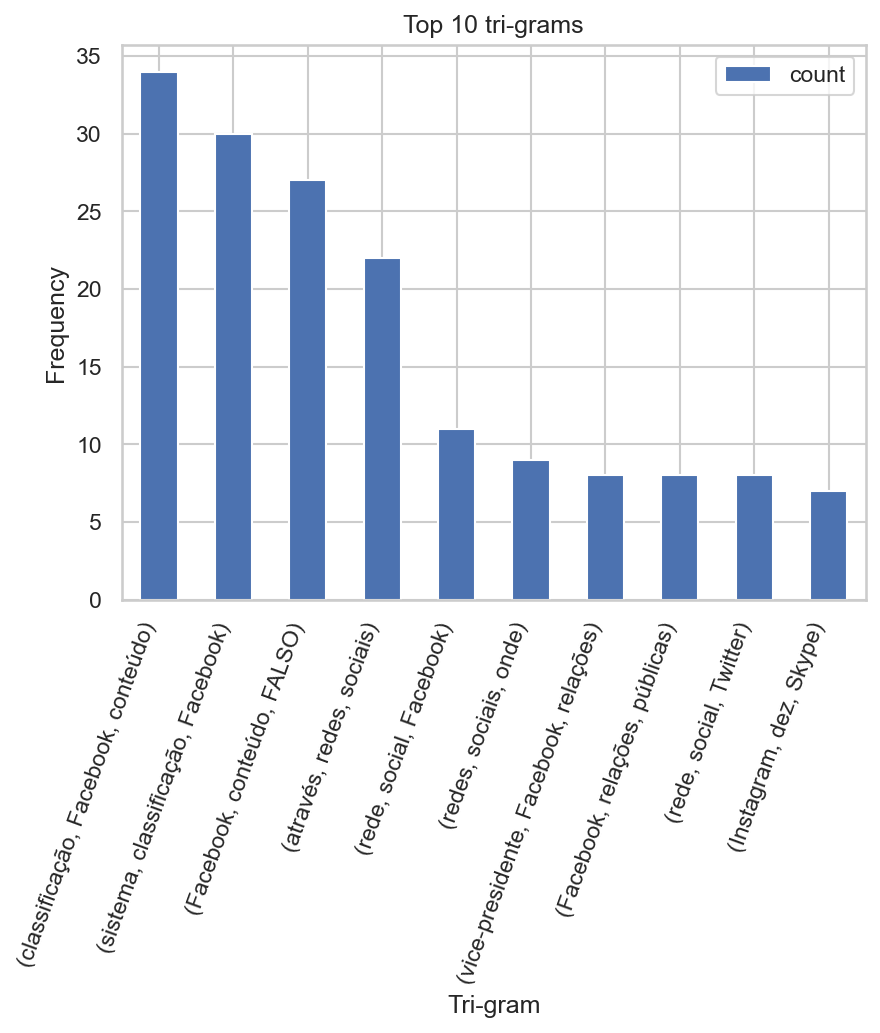

In [90]:
plt.figure(figsize=(10,6))
tri_grams_social_net_df.sort_values(by="count",ascending=False)[:10].plot.bar(x='trigram', y='count')
plt.xticks(rotation=70, ha="right")
plt.xlabel("Tri-gram")
plt.ylabel("Frequency")
plt.title("Top 10 tri-grams")
plt.show()

##### Bottom 10 tri-grams related to social network terms 

In [91]:
bottom_tri_grams_df = tri_grams_social_net_df.sort_values(by="count",ascending=True)[:10]
print(tabulate(bottom_tri_grams_df.reset_index(drop=True), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤════════════════════════════════════════════╤═════════╕
│    │ trigram                                    │   count │
╞════╪════════════════════════════════════════════╪═════════╡
│  0 │ ('feito', 'conta', 'Instagram')            │       1 │
├────┼────────────────────────────────────────────┼─────────┤
│  1 │ ('setor', 'Instagram', 'aplicações')       │       1 │
├────┼────────────────────────────────────────────┼─────────┤
│  2 │ ('Instagram', 'aplicações', 'manipulação') │       1 │
├────┼────────────────────────────────────────────┼─────────┤
│  3 │ ('intervenções', 'redes', 'sociais')       │       1 │
├────┼────────────────────────────────────────────┼─────────┤
│  4 │ ('redes', 'sociais', 'Ultimamente')        │       1 │
├────┼────────────────────────────────────────────┼─────────┤
│  5 │ ('redes', 'sociais', 'importância')        │       1 │
├────┼────────────────────────────────────────────┼─────────┤
│  6 │ ('aplicá-lo', 'redes', 'sociais')          │       1 │
├────┼──

##### Top 10 bi-grams related to mental health terms 

In [92]:
top_bi_grams_df = bi_grams_mental_health_df.sort_values(by="count",ascending=False)[:10]
print(tabulate(top_bi_grams_df.reset_index(drop=True), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═══════════════════════════════╤═════════╕
│    │ bigram                        │   count │
╞════╪═══════════════════════════════╪═════════╡
│  0 │ ('ansiedade', 'depressão')    │       4 │
├────┼───────────────────────────────┼─────────┤
│  1 │ ('depressão', 'ansiedade')    │       4 │
├────┼───────────────────────────────┼─────────┤
│  2 │ ('ataque', 'ansiedade')       │       3 │
├────┼───────────────────────────────┼─────────┤
│  3 │ ('sobre', 'depressão')        │       3 │
├────┼───────────────────────────────┼─────────┤
│  4 │ ('ataques', 'ansiedade')      │       3 │
├────┼───────────────────────────────┼─────────┤
│  5 │ ('stress', 'ansiedade')       │       3 │
├────┼───────────────────────────────┼─────────┤
│  6 │ ('alguma', 'ansiedade')       │       3 │
├────┼───────────────────────────────┼─────────┤
│  7 │ ('depressão', 'inseguranças') │       2 │
├────┼───────────────────────────────┼─────────┤
│  8 │ ('burnout', 'stress')         │       2 │
├────┼──────────────

##### Top 10 tri-grams related to mental health terms 

In [93]:
top_tri_grams_df = tri_grams_mental_health_df.sort_values(by="count",ascending=False)[:10]
print(tabulate(top_tri_grams_df.reset_index(drop=True), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤════════════════════════════════════════╤═════════╕
│    │ bigram                                 │   count │
╞════╪════════════════════════════════════════╪═════════╡
│  0 │ ('Serial', 'curiosidade', 'ansiedade') │       2 │
├────┼────────────────────────────────────────┼─────────┤
│  1 │ ('fria', 'associada', 'depressão')     │       2 │
├────┼────────────────────────────────────────┼─────────┤
│  2 │ ('diz', 'inglês', 'burnout')           │       2 │
├────┼────────────────────────────────────────┼─────────┤
│  3 │ ('inglês', 'burnout', 'stress')        │       2 │
├────┼────────────────────────────────────────┼─────────┤
│  4 │ ('burnout', 'stress', 'brutal')        │       2 │
├────┼────────────────────────────────────────┼─────────┤
│  5 │ ('sobre', 'depressão', 'inseguranças') │       2 │
├────┼────────────────────────────────────────┼─────────┤
│  6 │ ('histórias', 'sobre', 'depressão')    │       2 │
├────┼────────────────────────────────────────┼─────────┤
│  7 │ ('ansie